'''
https://github.com/LLNL/macc
'''

The JAG inertial confinement fusion simulation dataset for multi-modal scientific deep learning.

In [ ]:
%pip install ipynbname --quiet

Note: you may need to restart the kernel to use updated packages.


In [44]:
%pip -q install huggingface_hub
%pip install hf_xet

Note: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   --------------------- ------------------ 1.6/2.9 MB 12.0 MB/s eta 0:00:01
   ---------------------------------------- 2.9/2.9 MB 10.0 MB/s eta 0:00:00


In [ ]:
# Set cwd to the directory 
import os
from pathlib import Path
import ipynbname

HERE = Path(ipynbname.path()).resolve().parent
ROOT = HERE.parents[1]
os.chdir(HERE)
print("Current directory: ", os.getcwd())
os.chdir(ROOT)
print("Root directory:", os.getcwd())

Current directory:  C:\Users\384861\my_github\MORPH\experiments\ft_llnl_jag
Root directory: C:\Users\384861\my_github\MORPH


In [ ]:
datatset_dir = os.path.join(ROOT, "datasets")
data_dir = os.path.join(ROOT, "data")
model_dir = os.path.join(ROOT, "models")
results_dir = os.path.join(ROOT, "experiments", "results")
print("Dataset directory:", datatset_dir)
print("Data directory:", data_dir)
print("Model directory:", model_dir)
print("Results directory:", results_dir)

Dataset directory: C:\Users\384861\my_github\MORPH\datasets
Data directory: C:\Users\384861\my_github\MORPH\data
Model directory: C:\Users\384861\my_github\MORPH\models
Results directory: C:\Users\384861\my_github\MORPH\experiments\results


In [ ]:
import os, numpy as np

path_images = os.path.join(datatset_dir, "icf-jag-10k", "jag10K_images.npy")
path_params = os.path.join(datatset_dir, "icf-jag-10k", "jag10K_params.npy")
path_scalars = os.path.join(datatset_dir, "icf-jag-10k", "jag10K_0_scalars.npy")

images = np.load(path_images, allow_pickle=False)  
params = np.load(path_params, allow_pickle=False)
scalars = np.load(path_scalars, allow_pickle=False)

print("images.shape:", images.shape)
print("params.shape:", params.shape)
print("scalars.shape:", scalars.shape)

images.shape: (10000, 16384)
params.shape: (10000, 5)
scalars.shape: (10000, 15)


#### Data stats

In [ ]:
# some stats
min_images, max_images = images.min(), images.max()
mean_images, std_images = images.mean(), images.std()
print(f"images: min {min_images}, max {max_images}, mean {mean_images}, std {std_images}")

min_params, max_params = params.min(), params.max()
mean_params, std_params = params.mean(), params.std()
print(f"params: min {min_params}, max {max_params}, mean {mean_params}, std {std_params}")

min_scalars, max_scalars = scalars.min(), scalars.max()
mean_scalars, std_scalars = scalars.mean(), scalars.std()
print(f"scalars: min {min_scalars}, max {max_scalars}, mean {mean_scalars}, std {std_scalars}")

images: min 0.0, max 255.50160217285156, mean 1.0018655061721802, std 4.399370193481445
params: min -0.2999939999999354, max 0.9999943866084912, mean 0.20009702184750694, std 0.33403919837112045
scalars: min 0.0005003230180591345, max 0.9914026856422424, mean 0.30184993147850037, std 0.20122858881950378


#### Data visualizations

##### Scalars and Parameters

Text(0.5, 1.0, 'Parameters')

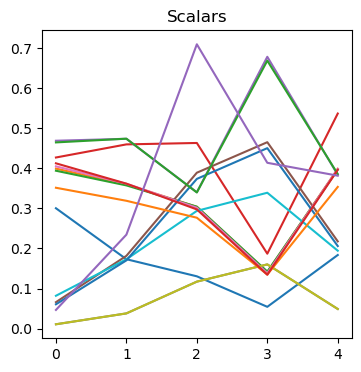

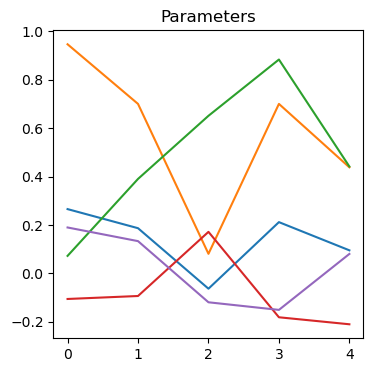

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(4, 4))
plt.plot(scalars[0:5,:],'-')
plt.title('Scalars')

plt.figure(figsize=(4, 4))
plt.plot(params[0:5,:],'-')
plt.title('Parameters')

##### Images

Reshaped images: (10000, 64, 64, 4)


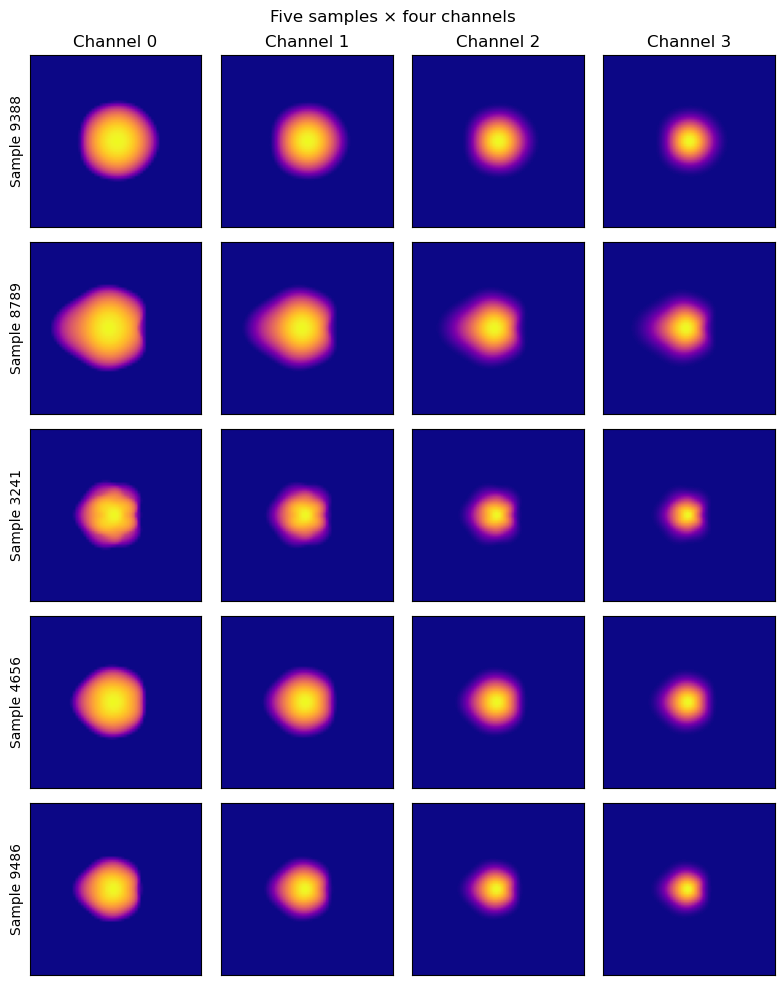

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# If not already reshaped:
images_reshape = images.reshape(images.shape[0], 64, 64, 4)
print(f"Reshaped images: {images_reshape.shape}")  # (N, 64, 64, 4)

# pick 5 unique samples
idxs = np.random.choice(images_reshape.shape[0], 5, replace=False)

fig, axes = plt.subplots(len(idxs), 4, figsize=(8, 2*len(idxs)))

# handle the case axes is 2D
for r, idx in enumerate(idxs):
    for c in range(4):
        ax = axes[r, c]
        ax.imshow(images_reshape[idx, :, :, c], cmap='plasma', origin='lower')
        ax.set_xticks([])
        ax.set_yticks([])
        if r == 0:
            ax.set_title(f'Channel {c}')
        if c == 0:
            ax.set_ylabel(f'Sample {idx}')

plt.suptitle('Five samples × four channels')
plt.tight_layout()
plt.show()

### Data Normalization
- We perform Reverse Instance Normalization (ReVIN) [Paper](https://openreview.net/forum?id=cGDAkQo1C0p).
- For every (Sample, Field), it calculates ($\mu$,$\sigma$)
- After training, ($\mu$,$\sigma$) can be used for denormalization

In [26]:
# Device information
import torch
print("Number of CUDA devices",torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Number of CUDA devices 1
Device: cuda


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

# dataset class
class DatasetforDataloader(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        # create a tuple
        return self.X[i], self.y[i]
    
# Dataset of dataloader
full_dataset = DatasetforDataloader(images_reshape, params)

# define the splits (80/10/10)
train_size = int(0.8 * images_reshape.shape[0])
val_size = int(0.1 * images_reshape.shape[0])
test_size = images_reshape.shape[0] - train_size - val_size

# Split the dataset 
train, val, test = torch.utils.data.random_split(full_dataset,[train_size, val_size, test_size])


In [21]:
# Dataloaders
BATCH_SIZE = 32
dataloader_train = DataLoader(train, batch_size = BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(val, batch_size = BATCH_SIZE, shuffle=False)
dataloader_test = DataLoader(test, batch_size = BATCH_SIZE, shuffle=False)

In [ ]:
# Instantiate the foundational model
from src.utils.vit_conv_xatt_axialatt2 import ViT3DRegression

MORPH_MODELS = {
    'Ti': [8, 256,  4,  4, 1024],
    'S' : [8, 512,  8,  4, 2048],
    'M' : [8, 768, 12,  8, 3072],
    'L' : [8, 1024,16, 16, 4096]
    }

model_size = MORPH_MODELS['Ti']  # choose from 'Ti', 'S', 'M', 'L'
filters, dim, depth, heads, mlp_dim = model_size
heads_xa = 32
dropout = 0.1
emb_dropout = 0.1
max_ar_order = 1
patch_size = 8
max_patches = 4096
max_fields = 3
max_components = 3

# lora settings
rank_lora_attn = 16
rank_lora_mlp = 16
lora_p = 0.05

morph = ViT3DRegression(patch_size=patch_size, dim=dim, depth=depth,
    heads=heads, heads_xa=heads_xa, mlp_dim=mlp_dim,
    max_components=max_components, conv_filter=filters,
    max_ar=max_ar_order,
    max_patches=max_patches, max_fields=max_fields,
    dropout=dropout, emb_dropout=emb_dropout,
    lora_r_attn=rank_lora_attn,            # <— rank of A and B in the attention module
    lora_r_mlp=rank_lora_mlp,              # <— rank of A and B in the MLP module
    lora_alpha=None,                       # defaults to 2*rank inside LoRA
    lora_p=lora_p                          # dropout on LoRA path
).to(device)

# print('Model architecture:', ft_model)
num_params_model = sum(p.numel() for p in morph.parameters()) / 1e6
print(f"→ NUMBER OF PARAMETERS OF THE MODEL (in M): {num_params_model:.3g}")


→ NUMBER OF PARAMETERS OF THE MODEL (in M): 10.6


In [ ]:
# load the foundational model weights
from huggingface_hub import hf_hub_download

# e.g., grab the "Ti" checkpoint (change filename as needed)
weights_path = hf_hub_download(
    repo_id="mahindrautela/MORPH",
    filename="morph-Ti-FM-max_ar1_ep225.pth",
    subfolder="models/FM",
    repo_type="model",              # optional
    resume_download=True,           # continue if interrupted
    local_dir="weights/FM",         # where to place it
    local_dir_use_symlinks=False    # copy file instead of symlink
)
print(weights_path)

weights\FM\models\FM\morph-Ti-FM-max_ar1_ep225.pth


c:\Users\384861\.conda\envs\pytorch_latxformer\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\384861\.conda\envs\pytorch_latxformer\lib\site-packages\huggingface_hub\file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


In [51]:
#%% Load weights
import torch.nn as nn

# ---- load the pretrained weights ----
start_epoch = 0
print(f"→ Loading checkpoints from {weights_path}")
# --- Load pretrained checkpoint from foundational model ---
ckpt = torch.load(weights_path, map_location=device, weights_only=True)
state_dict = ckpt["model_state_dict"]

# pick the real model if wrapped   
target = morph.module if isinstance(morph, nn.DataParallel) else morph 

if state_dict and next(iter(state_dict)).startswith("module."):
    print("→ Stripping 'module.' from checkpoints")
    state_dict = {k.replace("module.", "", 1): v for k, v in state_dict.items()}
    
# strict=False because ft_model has extra LoRA params (A/B) not in ckpt
missing, unexpected = target.load_state_dict(state_dict, strict=False)

# sanity print
print("Missing keys (expected: LoRA A/B etc.):",
        [k for k in missing if k.endswith((".A", ".B")) or ".lora" in k])
print("Unexpected keys:", unexpected)
print(f"→ Resumed from {weights_path}, starting at epoch {start_epoch}")


→ Loading checkpoints from weights\FM\models\FM\morph-Ti-FM-max_ar1_ep225.pth
→ Stripping 'module.' from checkpoints
Missing keys (expected: LoRA A/B etc.): ['transformer_blocks.0.axial_attn.attn_t.q.A', 'transformer_blocks.0.axial_attn.attn_t.q.B', 'transformer_blocks.0.axial_attn.attn_t.k.A', 'transformer_blocks.0.axial_attn.attn_t.k.B', 'transformer_blocks.0.axial_attn.attn_t.v.A', 'transformer_blocks.0.axial_attn.attn_t.v.B', 'transformer_blocks.0.axial_attn.attn_t.o.A', 'transformer_blocks.0.axial_attn.attn_t.o.B', 'transformer_blocks.0.axial_attn.attn_d.q.A', 'transformer_blocks.0.axial_attn.attn_d.q.B', 'transformer_blocks.0.axial_attn.attn_d.k.A', 'transformer_blocks.0.axial_attn.attn_d.k.B', 'transformer_blocks.0.axial_attn.attn_d.v.A', 'transformer_blocks.0.axial_attn.attn_d.v.B', 'transformer_blocks.0.axial_attn.attn_d.o.A', 'transformer_blocks.0.axial_attn.attn_d.o.B', 'transformer_blocks.0.axial_attn.attn_h.q.A', 'transformer_blocks.0.axial_attn.attn_h.q.B', 'transformer_b

In [ ]:
# Task-specific head model
import torch
import torch.nn as nn

class TaskSpecificHead_CNN1D(nn.Module):
    def __init__(self, n_patches=64, feat_dim=256, output_dim=5, dropout_p=0.1):
        super(TaskSpecificHead_CNN1D, self).__init__()
        self.n_patches = n_patches
        self.feat_dim = feat_dim

        self.conv1 = nn.Conv1d(in_channels=feat_dim, out_channels=128, kernel_size=3, padding=1)  # L stays 64
        self.conv2 = nn.Conv1d(in_channels=128,      out_channels=64,  kernel_size=3, padding=1)  # L stays /2 after pool
        self.conv3 = nn.Conv1d(in_channels=64,       out_channels=32,  kernel_size=3, padding=1)  # L stays /2 after pool

        self.act = nn.GELU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  # halves length each time: 64->32->16->8
        self.drop = nn.Dropout(dropout_p)
        self.flat = nn.Flatten()

        feat_len = n_patches // 8            # 64 -> 8 after three pools
        self.fc = nn.Linear(32 * feat_len, output_dim)

    def forward(self, x):
        x = x.view(-1, self.n_patches, self.feat_dim)  # (B, 64, 256)
        x = self.pool(self.act(self.conv1(x)))  # (B,128,32)
        x = self.drop(x)
        x = self.pool(self.act(self.conv2(x)))  # (B, 64,16)
        x = self.drop(x)
        x = self.pool(self.act(self.conv3(x)))  # (B, 32, 8)
        x = self.flat(x)                        # (B, 32*8 = 256)
        x = self.drop(x)
        return self.fc(x)                       # (B, output_dim)

    
# Instantiate the model - 1
N_patches = 64
feat_per_patch = 256 
input_dim = N_patches * feat_per_patch
output_dim = params.shape[1]  # number of parameters to predict
head = TaskSpecificHead_CNN1D(N_patches, feat_per_patch, output_dim).to(device)
print("Num params encoder (in K): ", sum(p.numel()//10**3 for p in head.parameters()))
print('Model architecture', head)

Num params encoder (in K):  129
Model architecture TaskSpecificHead_CNN1D(
  (conv1): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (act): GELU(approximate='none')
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.1, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


In [ ]:
#%% Fine-tuning setup
from src.utils.crossattention_fields import FieldCrossAttention
from src.utils.convolutional_operator import ConvOperator
from src.utils.lora_linear import LoRALinear
import torch.nn as nn
import torch

'''
Level-1 (latent space): MHA, MLP via LoRA, Norms, Pos-enc
Level-2 ( + Encoding): Conv, Proj (linear), Cross-attention
'''

class SelectFineTuningParameters:
    def __init__(self, ft_model, ft_level = 1):
        self.ft_model = ft_model
        self.ft_level = ft_level

    def configure_levels(self):
        # ---------- Common: start by freezing everything ----------
        for p in self.ft_model.parameters():
            p.requires_grad_(False)

        # Collect params per level
        lora_params, norm_params, pe_params = [], [], []
        conv_params, proj_params, xattn_params = [], [], []

        #######################################################################
        # --- Level - 1 (LoRA in latent, LayerNorms, Pos-encoding) -----------
        #######################################################################

        if self.ft_level == 1 or self.ft_level == 12:
            print('→ Level-1 Finetuning (latent space) activated')
            TRAIN_NORMS  = True
            TRAIN_POSENC = True

            # LoRA + LayerNorms
            for m in self.ft_model.modules():
                # LoRA: enable only A/B
                if isinstance(m, LoRALinear) and getattr(m, "rank", 0) > 0:
                    if m.A is not None:
                        m.A.requires_grad_(True); lora_params.append(m.A)
                    if m.B is not None:
                        m.B.requires_grad_(True); lora_params.append(m.B)

                # LayerNorms
                if TRAIN_NORMS and isinstance(m, nn.LayerNorm):
                    for p in m.parameters(recurse=False):
                        p.requires_grad_(True); norm_params.append(p)

            # Positional encoding (handle DP)
            root = getattr(self.ft_model, "module", self.ft_model)
            if TRAIN_POSENC and hasattr(root, "pos_encoding"):
                for p in root.pos_encoding.parameters(recurse=False):
                    p.requires_grad_(True); pe_params.append(p)

        #######################################################################
        # --- Level - 2 (Conv, Linear projection, Cross-attention) ------------
        #######################################################################

        if self.ft_level == 2 or self.ft_level == 12:
            print('→ Level-2 Finetuning (Encoding) activated')
            TRAIN_CONV, TRAIN_PROJ, TRAIN_XATTN = True, True, True

            root = getattr(self.ft_model, "module", self.ft_model)
            pe = getattr(root, "patch_embedding", None)
            if pe is None:
                raise RuntimeError("[Level-2] patch_embedding not found on model")

            # Conv encoder
            if TRAIN_CONV and hasattr(pe, "conv_features"):
                cf = pe.conv_features
                if isinstance(cf, ConvOperator):
                    for p in cf.parameters():
                        p.requires_grad_(True); conv_params.append(p)
                else:
                    print("[Level-2] conv_features exists but is not ConvOperator")

            # Projection layer
            if TRAIN_PROJ and hasattr(pe, "projection"):
                for p in pe.projection.parameters(recurse=False):
                    p.requires_grad_(True); proj_params.append(p)

            # Cross-attention over fields
            if TRAIN_XATTN and hasattr(pe, "field_attn"):
                xa = pe.field_attn
                if isinstance(xa, FieldCrossAttention):
                    for p in xa.parameters():
                        p.requires_grad_(True); xattn_params.append(p)
                else:
                    print("[Level-2] field_attn exists but is not FieldCrossAttention")

        # ---------- Build optimizer once from collected groups ----------
        param_groups = []
        if lora_params: param_groups.append({'params': lora_params, 'lr': 1e-3, 'weight_decay': 0.0})
        if norm_params: param_groups.append({'params': norm_params, 'lr': 1e-4, 'weight_decay': 0.0})
        if pe_params:   param_groups.append({'params': pe_params,   'lr': 1e-4, 'weight_decay': 0.0})
        if conv_params: param_groups.append({'params': conv_params, 'lr': 1e-4, 'weight_decay': 1e-5})
        if proj_params: param_groups.append({'params': proj_params, 'lr': 1e-4, 'weight_decay': 1e-5})
        if xattn_params:param_groups.append({'params': xattn_params,'lr': 1e-4, 'weight_decay': 1e-5})

        if not param_groups:
            raise RuntimeError("No parameters selected for fine‑tuning. "
                               "Did you pass any of --ft_level1/2/3 or --ft_level4?")

        optimizer = torch.optim.AdamW(param_groups)

        # ---------- Summaries ----------
        if self.ft_level == 1 or self.ft_level == 12:
            print(f"[Level-1] unfrozen → LoRA(A+B): {sum(p.numel() for p in lora_params)/1e6:.3f}M | "
                  f"norms: {sum(p.numel() for p in norm_params)/1e6:.3f}M | "
                  f"pos-enc: {sum(p.numel() for p in pe_params)/1e6:.3f}M")
        if self.ft_level == 2 or self.ft_level == 12:
            print(f"[Level-2] unfrozen → conv: {sum(p.numel() for p in conv_params)/1e6:.3f}M | "
                  f"proj: {sum(p.numel() for p in proj_params)/1e6:.3f}M | "
                  f"xattn: {sum(p.numel() for p in xattn_params)/1e6:.3f}M")
        
        # print model parameters
        total_params = sum(p.numel() for p in self.ft_model.parameters()) / 1e6
        trainable_params = sum(p.numel() for p in self.ft_model.parameters() if p.requires_grad) / 1e6
        print(f"→ TOTAL PARAMS (M): {total_params:.3f} | TRAINABLE (M): {trainable_params:.3f}")
        
        return optimizer


In [ ]:
#%% Fine-tuning setup
from src.utils.select_fine_tuning_parameters import SelectFineTuningParameters
ft_level = 12  # choose desired level
selector = SelectFineTuningParameters(morph, ft_level=ft_level)
optimizer_1 = selector.configure_levels()

In [ ]:
# Loss function and optimizer
import torch.optim as optim
optimizer_2 = optim.Adam(head.parameters(), lr=1e-4)

In [ ]:
# Loss function
loss_fn = nn.MSELoss()

In [ ]:
# Standalone model
import torch.nn as nn

class Standalone_CNN2D(nn.Module):
    def __init__(self, output_dim=5):
        super(Standalone_CNN2D, self).__init__()
        # 64x64 input with 4 channels
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, padding=1)   # -> 32 x 64 x 64
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # -> 64 x 32 x 32 (after pool)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # -> 128 x 16 x 16 (after pool)

        self.activation = nn.GELU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # halves H and W
        self.dropout = nn.Dropout(0.1)
        self.flatten = nn.Flatten()

        # After three 2x2 pools: 64 -> 32 -> 16 -> 8
        # So features = 128 * 8 * 8 = 8192
        self.fc = nn.Linear(128 * 8 * 8, output_dim)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))  # 32 x 32 x 32
        x = self.dropout(x)
        x = self.pool(self.activation(self.conv2(x)))  # 64 x 16 x 16
        x = self.dropout(x)
        x = self.pool(self.activation(self.conv3(x)))  # 128 x 8 x 8
        x = self.flatten(x)                            # 8192
        x = self.dropout(x)
        return self.fc(x)                              # logits of shape (B, output_dim)
    
# Instantiate the model - 2
output_dim = params.shape[1]  # number of parameters to predict
model_2 = Standalone_CNN2D(output_dim).to(device)
print("Num params encoder (in K): ", sum(p.numel()//10**3 for p in model_2.parameters()))
print('Model architecture', model_2)

Num params encoder (in K):  132
Model architecture Standalone_CNN(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation): GELU(approximate='none')
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=8192, out_features=5, bias=True)
)


In [ ]:
# Trainer class
class Trainer:
    @staticmethod
    def train_epoch(model_1, model_2, optimizer_1, optimizer_2, device, dataloader_train):
        model_1.train() 
        model_2.train()
        train_loss_1 = []
        train_loss_2 = []
        for step, batch in enumerate(dataloader_train):
            x_tr, y_tr = batch
            x_tr, y_tr = x_tr.to(device), y_tr.to(device)
            optimizer_1.zero_grad()
            optimizer_2.zero_grad()
            # Model 1 forward + backward
            y_hat_1 = model_1(x_tr)
            loss_1 = loss_fn(y_hat_1, y_tr)
            loss_1.backward()
            optimizer_1.step()
            train_loss_1.append(loss_1.item())

            # Model 2 forward + backward
            y_hat_2 = model_2(x_tr)
            loss_2 = loss_fn(y_hat_2, y_tr)
            loss_2.backward()
            optimizer_2.step()
            train_loss_2.append(loss_2.item())

        return np.mean(train_loss_1), np.mean(train_loss_2)

    @staticmethod
    def test_epoch(model_1, model_2, device, dataloader_test):
        model_1.eval() # Set the eval mode for model
        model_2.eval()
        test_loss_1 = []
        test_loss_2 = []
        with torch.no_grad(): # No need to track the gradients
            for step, batch in enumerate(dataloader_test):
                x_val, y_val = batch
                x_val, y_val = x_val.to(device), y_val.to(device)

                # Model 1 forward
                y_hat_1 = model_1(x_val)
                loss_1 = loss_fn(y_hat_1, y_val)
                test_loss_1.append(loss_1.item())
                
                # Model 2 forward
                y_hat_2 = model_2(x_val)
                loss_2 = loss_fn(y_hat_2, y_val)
                test_loss_2.append(loss_2.item())

        return np.mean(test_loss_1), np.mean(test_loss_2)

In [ ]:
num_epochs = 100
diz_loss = {'train_loss':[],'val_loss':[]}
model = model_1  # or model_2
optimizer = optimizer_1  # or optimizer_2

for epoch in range(num_epochs):
   train_loss, tr_bce, tr_kl = Trainer.train_epoch(model, device, dataloader_train, optimizer)
   val_loss, val_bce, val_kl = Trainer.test_epoch(model, device, dataloader_val)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'
         .format(epoch + 1, num_epochs, train_loss, val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)

# Save the model
torch.save(model.state_dict(), 'dense_model_icf.pth') 